In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, '../')

import experiment
import pickle
from utils import *
from Architectures import *
import random, os
suppress_warnings()
EPOCHS = 256


def countp(model, params):
    tmp = model(**params)
    tmp.build(input_shape=(1,15,7))
    return tmp.count_params()


n_params = []

os.environ['PYTHONHASHSEED']=str(0)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.0f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])


filename = '../data/data100k_raw_combined_atlas_cut.pkl'
n_experiments = 8
SUFFIX = 'latent28'


#TESTING ######
# EPOCHS = 2
# filename = '../data/data50k_raw_combined_atlas_cut_small.pkl'
# n_experiments = 2
# SUFFIX = 'latent28'
###########

ERROR in cling::CIFactory::createCI(): cannot extract standard library include paths!
Invoking:
  LC_ALL=C x86_64-conda-linux-gnu-c++  -O3 -DNDEBUG -xc++ -E -v /dev/null 2>&1 | sed -n -e '/^.include/,${' -e '/^ \/.*++/p' -e '}'
Results was:
With exit code 0


Welcome to JupyROOT 6.22/08


2022-08-05 14:36:51.784654: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import seaborn as sns
import os

#to get latex to work 
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']


PIl64 = experiment.Experimenter(filename)
PIl64.fromSaved()

PI = experiment.Experimenter(filename)
PI.fromSaved(suffix=SUFFIX)

Initializing Experimenter
	Loading Data from ../data/data100k_raw_combined_atlas_cut.pkl
	Data Loaded
	Creating Splits
	Splits Created
Done initalizing
Loading Experimenter from Saved Experimenter at /data/delon/experimenter/data100k_raw_combined_atlas_cut
Experimenter Loaded
Getting split
Split Stored
Loading models
{'nested_concat_70_4_64_3': 'models/data100k_raw_combined_atlas_cut_nested_concat_70_4_64_3', 'nested_concat_general_68_3_64_3': 'models/data100k_raw_combined_atlas_cut_nested_concat_general_68_3_64_3', 'particlewise_128_4_64': 'models/data100k_raw_combined_atlas_cut_particlewise_128_4_64', 'tripletwise_5_(64, 128, 256, 128, 64)_64': 'models/data100k_raw_combined_atlas_cut_tripletwise_5_(64, 128, 256, 128, 64)_64', 'pairwise_5_(64, 128, 256, 128, 64)_64': 'models/data100k_raw_combined_atlas_cut_pairwise_5_(64, 128, 256, 128, 64)_64', 'pairwise_nl_5_(64, 128, 256, 128, 64)_32_64': 'models/data100k_raw_combined_atlas_cut_pairwise_nl_5_(64, 128, 256, 128, 64)_32_64', 'pairwis

2022-08-05 14:37:20.030571: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-08-05 14:37:20.047614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:84:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-08-05 14:37:20.048641: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:85:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-08-05 14:37:20.048675: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-08-05 14:37:20.052970: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-05 14:3

In [4]:
latent64 = PIl64.models['%s_%s'%('pairwise', PIl64.get_tail_string(model_params_dict['pairwise']))]
latent2 = PI.models['latent_two_5_(64, 128, 256, 128, 2)_64']
latent8 = PI.models['latent_eight_5_(64, 128, 256, 128, 8)_64']

In [5]:
PI.get_ROC('latent_two', model_params_dict['latent_two'])

getting ROC for latent_two
currently on latent_two_5_(64, 128, 256, 128, 2)_64


(array([0.        , 0.        , 0.        , ..., 0.9779992 , 0.97806607,
        1.        ]),
 array([0.00000000e+00, 3.32314236e-05, 4.95148212e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.99984789e+00, 9.99847889e-01, 9.98715162e-01, ...,
        2.04723401e-05, 2.04274475e-05, 1.10760734e-10], dtype=float32),
 0.9602683007898865)

2022-08-05 14:37:53.085862: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-05 14:37:53.086781: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2099935000 Hz
2022-08-05 14:37:55.094973: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-08-05 14:37:55.896804: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2022-08-05 14:37:57.166390: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-05 14:37:57.755030: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


In [6]:
X_test_latent, y_test_latent = PI.get_test_dataset('latent_two')
X_test, y_test = PIl64.get_test_dataset('pairwise')


In [7]:
X_test_ATLAS, y_test_ATLAS = gen_dataset_high_level(PIl64.events_test, PIl64.events_oup_test, PIl64.events_tag_test)

In [8]:
n_cut = int(len(X_test)*0.1)
n_cut = 15000
assert(len(X_test) == len(X_test_latent))

indices = np.random.permutation(len(X_test))
cut = np.s_[indices[:n_cut]]

latent_label = y_test.numpy()[cut]
latent_label_28 = y_test_latent.numpy()[cut]

In [9]:
print(n_cut)

15000


In [21]:
latent64_embedded = compute_tsne(latent64, X_test=X_test, cut=cut)

64
computing tsne
--------------------------------------------------------------------------------
TSNE(initialization='random', metric='cosine', n_jobs=-1, perplexity=1000,
     random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 3000 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 17.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 47.62 seconds
===> Running optimization with exaggeration=12.00, lr=1250.00 for 250 iterations...
Iteration   50, KL divergence 2.5641, 50 iterations in 5.6409 sec
Iteration  100, KL divergence 2.4571, 50 iterations in 5.5347 sec
Iteration  150, KL divergence 2.4009, 50 iterations in 5.3434 sec
Iteration  200, KL divergence 2.4009, 50 iterations in 5.5116 sec
Iteration  250, KL divergence 2.4009, 50 iterations in 5.4664 sec
   --> Time elapsed: 27.50 seconds
===> Running optimization with exaggeration=1.00, lr=1250.00 f

In [22]:
ATLAS_embedded = compute_tsne_embedded(np.array(X_test_ATLAS)[cut])

8
computing tsne
--------------------------------------------------------------------------------
TSNE(initialization='random', metric='cosine', n_jobs=-1, perplexity=1000,
     random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 3000 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 17.23 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 48.10 seconds
===> Running optimization with exaggeration=12.00, lr=1250.00 for 250 iterations...
Iteration   50, KL divergence 2.6297, 50 iterations in 5.4574 sec
Iteration  100, KL divergence 2.3493, 50 iterations in 5.4995 sec
Iteration  150, KL divergence 2.3484, 50 iterations in 5.4718 sec
Iteration  200, KL divergence 2.3484, 50 iterations in 5.4545 sec
Iteration  250, KL divergence 2.3484, 50 iterations in 4.9657 sec
   --> Time elapsed: 26.85 seconds
===> Running optimization with exaggeration=1.00, lr=1250.00 fo

In [23]:
latent8_embedded = compute_tsne(latent8, cut=cut, X_test=X_test_latent)

8
computing tsne
--------------------------------------------------------------------------------
TSNE(initialization='random', metric='cosine', n_jobs=-1, perplexity=1000,
     random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 3000 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 17.46 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 47.65 seconds
===> Running optimization with exaggeration=12.00, lr=1250.00 for 250 iterations...
Iteration   50, KL divergence 2.6086, 50 iterations in 5.4540 sec
Iteration  100, KL divergence 2.4265, 50 iterations in 5.5200 sec
Iteration  150, KL divergence 2.4235, 50 iterations in 5.3222 sec
Iteration  200, KL divergence 2.4235, 50 iterations in 5.4571 sec
Iteration  250, KL divergence 2.4235, 50 iterations in 5.4426 sec
   --> Time elapsed: 27.20 seconds
===> Running optimization with exaggeration=1.00, lr=1250.00 fo

In [19]:
latent2_embedded = compute_tsne(latent2, cut=cut, X_test=X_test_latent, perplexity=[1000,1998])

2
computing tsne
--------------------------------------------------------------------------------
TSNE(initialization='random', n_jobs=-1, perplexity=1000, random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 3000 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 20.85 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 43.07 seconds
===> Running optimization with exaggeration=12.00, lr=1250.00 for 250 iterations...
Iteration   50, KL divergence 2.6439, 50 iterations in 5.5000 sec
Iteration  100, KL divergence 2.0034, 50 iterations in 5.5633 sec
Iteration  150, KL divergence 1.9476, 50 iterations in 5.5274 sec
Iteration  200, KL divergence 1.9477, 50 iterations in 5.5005 sec
Iteration  250, KL divergence 1.9477, 50 iterations in 5.2743 sec
   --> Time elapsed: 27.37 seconds
===> Running optimization with exaggeration=1.00, lr=1250.00 for 500 iteratio

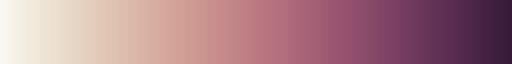

In [14]:
sns.cubehelix_palette(start=2/10, light=.97, as_cmap=True)

[-1.44003328e-16  5.30538576e-17] [9.12618068 9.04338386]
computing EMD with N= 15000
computed EMD with N=15000
	EMD: 0.742
earth_movers_distance 0.7417435061464566


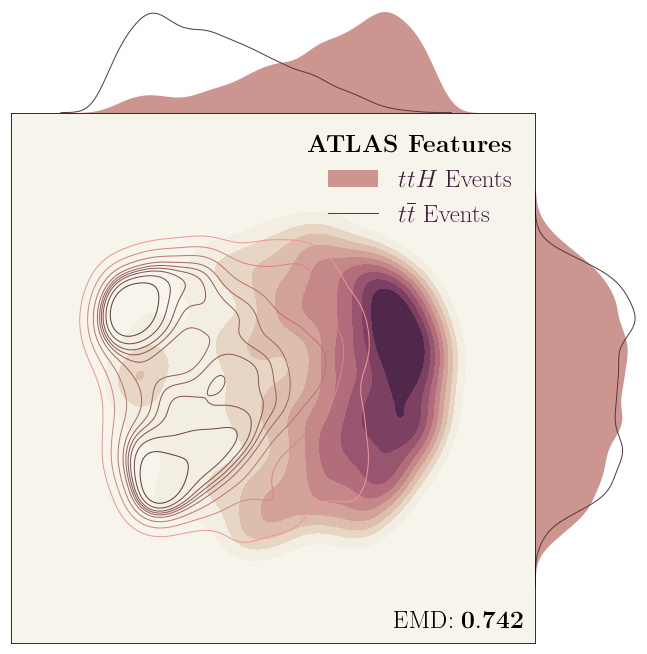

In [24]:
axATLAS = gen_tsne(ATLAS_embedded, latent_label, text=r'\textbf{ATLAS Features}',
                   cmap = sns.cubehelix_palette(start=2/10, light=.97, as_cmap=True), col_aux='#f49595')
axATLAS.savefig('figures/ATLAS_tsne.pdf')

[ 3.24007488e-16 -4.54747351e-17] [14.73072588  6.65449338]
computing EMD with N= 15000
computed EMD with N=15000
	EMD: 0.813
earth_movers_distance 0.8126986708839647


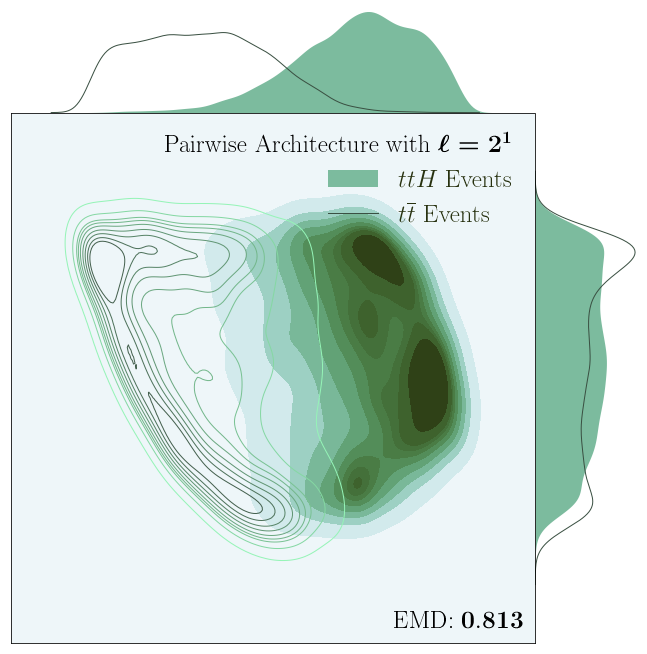

In [20]:
ax = gen_tsne(latent2_embedded, latent_label_28, text=r'{Pairwise Architecture with} \boldmath$\mathbf{\ell=2^1}$',
             cmap=sns.cubehelix_palette(start=14/10, light=.97, as_cmap=True), col_aux='#95f4b7')
ax.savefig('figures/l2_tsne.pdf')

[-2.27373675e-17 -1.32634644e-17] [10.56041457  5.03457571]
computing EMD with N= 15000
computed EMD with N=15000
	EMD: 0.909
earth_movers_distance 0.909483140337614


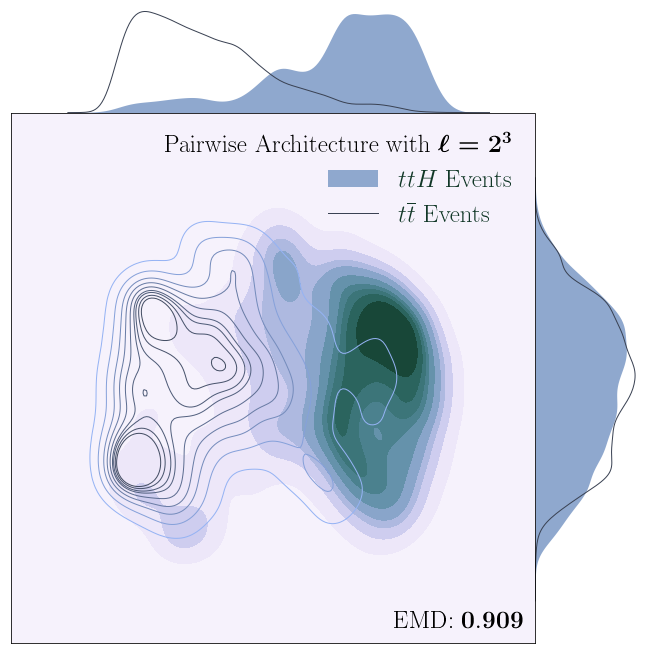

In [25]:
ax = gen_tsne(latent8_embedded, latent_label_28, text=r'{Pairwise Architecture with} \boldmath$\mathbf{\ell=2^3}$',
              cmap=sns.cubehelix_palette(start=20/10, light=.97, as_cmap=True), col_aux='#95b3f4')
ax.savefig('figures/l8_tsne.pdf')

[1.97057185e-16 1.55372012e-16] [7.19175692 5.69874932]
computing EMD with N= 15000
computed EMD with N=15000
	EMD: 0.952
earth_movers_distance 0.9521729347244041


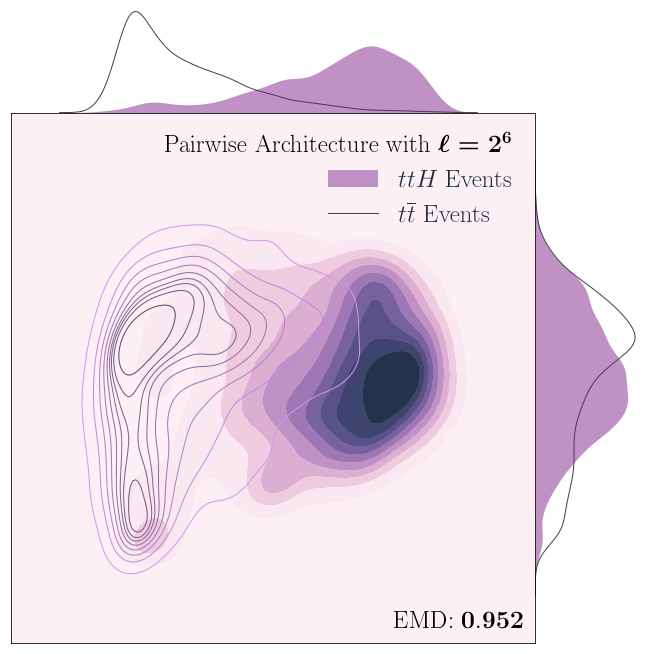

In [26]:
axl64 = gen_tsne(latent64_embedded, latent_label, text=r'{Pairwise Architecture with} \boldmath$\mathbf{\ell=2^6}$ ',
                )
axl64.savefig('figures/l64_tsne.pdf')

In [ ]:
from utils import *
metric='euclidean'
emds = {}

emds['ATLAS'] = emd(np.array(X_test_ATLAS), y_test.numpy(), metric=metric)
emds['l2']    = compute_to_emd(latent2,  X_test=X_test_latent, latent_label=y_test_latent.numpy(), metric=metric)
emds['l8']    = compute_to_emd(latent8,  X_test=X_test_latent, latent_label=y_test_latent.numpy(), metric=metric)
emds['l64']   = compute_to_emd(latent64, X_test=X_test_latent, latent_label=y_test.numpy(),   metric=metric)

In [ ]:
for key in emds:
    print('%10s: %.3f'%(key, emds[key]))

In [ ]:
from utils import *
metric='euclidean'
emds_test = {}

emds_test['ATLAS'] = emd(np.array(X_test_ATLAS), y_test.numpy(), testing=True , metric=metric)
emds_test['l2']    = compute_to_emd(latent2,  X_test=X_test_latent, latent_label=y_test_latent.numpy(), testing=True,  metric=metric)
emds_test['l8']    = compute_to_emd(latent8,  X_test=X_test_latent, latent_label=y_test_latent.numpy(),testing=True,   metric=metric)
emds_test['l64']   = compute_to_emd(latent64, X_test=X_test_latent, latent_label=y_test.numpy(), testing=True,    metric=metric)

In [ ]:
for key in emds_test:
    print('%10s: %.3f'%(key, emds_test[key]))

In [ ]:
def temp_temp(p0, p1):
    log=False
    cmap=sns.cubehelix_palette(start=26/10, light=.97, as_cmap=True)
    c_cut = 5
    col_aux='#d495f4'
    text=''
    g = sns.jointplot(x=p0[:,0], y = p0[:,1], color=cmap(100), space=0, label='ttH jets',
                      cmap=cmap, kind='kde', height=10, fill=True, cut=c_cut,
                     marginal_kws={'linewidth': 0.0, 'alpha':1.0, 'log_scale':log},
                     joint_kws={'log_scale':log})

    linew = 1
    bgrey = sns.dark_palette(col_aux, reverse=True, as_cmap=True)
    COL2 = bgrey(.8)
    sns.kdeplot(x=p1[:,0], y = p1[:,1], shade=False, label=r'ttbar jets',cmap=bgrey, linewidths=linew, cut=c_cut, 
                levels=10, ax=g.ax_joint, log_scale=False)

    sns.kdeplot(p1[:,0], ax=g.ax_marg_x, color=COL2, lw=linew, log_scale=log)
    sns.kdeplot(y=p1[:,1], ax=g.ax_marg_y, color=COL2, lw=linew, log_scale=log)

    ax = g.ax_joint

    import matplotlib.patches as  mpatches
    import matplotlib.lines as  mlines

    handles = [mpatches.Patch(facecolor=cmap(100), label=r'$ttH$ Events'),
               mlines.Line2D([], [], color=COL2, label=r'$t\overline{t}$ Events', lw=linew)]
    legend = ax.legend(loc='upper right', handles=handles, frameon=False, title=text)
    legend._legend_box.align = 'right'

    plt.setp(legend.get_texts(), color=cmap(0.98))
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 25
    plt.rcParams['figure.autolayout'] = True

    ax.set_facecolor(cmap(c_cut))

In [ ]:
latent_getter = LatentGetter(latent2.layers[0:3], condensed=True)
latent_reps = latent_getter.predict(X_test_latent.numpy())

In [ ]:
print(latent_reps[:5])
print((np.argsort(np.argsort(latent_reps[:5].T))).T)

In [ ]:
p0, p1 = emd(latent_reps, latent_label=y_test_latent.numpy(), metric=metric, only_compute=True)
temp_temp(p0,p1)

In [ ]:
p0, p1 = emd(latent_reps, latent_label=y_test_latent.numpy(), metric=metric, only_compute=True, scale=False)
temp_temp(p0,p1)

In [ ]:
p0, p1 = emd(latent_reps, latent_label=y_test_latent.numpy(), metric=metric, only_compute=True, scale=False, remove_outlier=True)
temp_temp(p0,p1)

In [ ]:
p0, p1 = emd(latent_reps, latent_label=y_test_latent.numpy(), metric=metric, only_compute=True, scale=True, remove_outlier=True)
temp_temp(p0,p1)

In [ ]:
NN=1000
x = np.array([[a+1/2, a**2] for a in np.linspace(0,10,NN)])
y = np.array([[a+5/2, a**(1/2)] for a in np.linspace(0,10,NN)])
temp_temp(x,y)

In [ ]:
NN=1000
x = np.array([[a+1/2, a**2] for a in np.linspace(0,10,NN)])
y = np.array([[a+5/2, a**(1/2)] for a in np.linspace(0,10,NN)])
temp_temp(p0, p1)

In [ ]:
mu, sigma = 0, 0.1 
p0 = np.stack([np.random.normal(0, 5, 1000), np.random.normal(0, 5, 1000)]).T
p1 = np.stack([np.random.normal(10, 5, 1000), np.random.normal(10, 5, 1000)]).T
z = np.concatenate([p0,p1])
z = quantile_scale(z)
p0 = z[:1000]
p1 = z[1000:]

temp_temp(p0,p1)

In [ ]:
mu, sigma = 0, 0.1 
p0 = np.stack([np.random.normal(0, 5, 1000), np.random.normal(0, 5, 1000)]).T
p1 = np.stack([np.random.normal(10, 5, 1000), np.random.normal(10, 5, 1000)]).T
temp_temp(p0,p1)

In [ ]:
emdrand = {}
for i in [2,8,64]:
    t1 = np.array([[np.random.uniform() for _ in range(i)] for _ in range(15000)])
    t2 = np.array([[np.random.uniform() for _ in range(i)] for _ in range(15000)])
    for j in [1000,3000,7000]:
        emdrand['l%d_N%d'%(i,j)] = earth_movers_distance(t1, t2, metric=metric, N=j)

In [ ]:
print('RANDOM EVENTS')
for a in emdrand:
    print('%8s: %.3f'%(a, emdrand[a]))

In [ ]:
for a in emds:
    print('%8s: %.3f'%(a, emds[a]))

In [ ]:

emd(np.array(X_test_ATLAS), y_test.numpy(), metric=metric, converging=True)

In [ ]:
metric='euclidean'

print(emd(np.array(X_test_ATLAS)[cut], latent_label, metric=metric), 
      emd(np.array(X_test_ATLAS)[cut], latent_label, metric=metric, testing=True))

In [ ]:
quantile = lambda x:(x+1/2)
a = np.array([[1,3,-1],[2,1,3],[5,7,-2]])
print(a)
print(a.T)
print(np.argsort(a.T))
print(quantile(np.argsort(a.T)))
print(quantile(np.argsort(a.T))/len(a.T[0]))
print((quantile(np.argsort(a.T))/len(a.T[0])).T)

In [ ]:
metric='euclidean'
emd(np.array(X_test_ATLAS), y_test.numpy(), metric=metric, converging=True, testing=True)

In [ ]:
for key in emds:
    print('%10s: %.2f'%(key, emds[key]))

[9.662037 8.027242] [12.327544  9.813144]


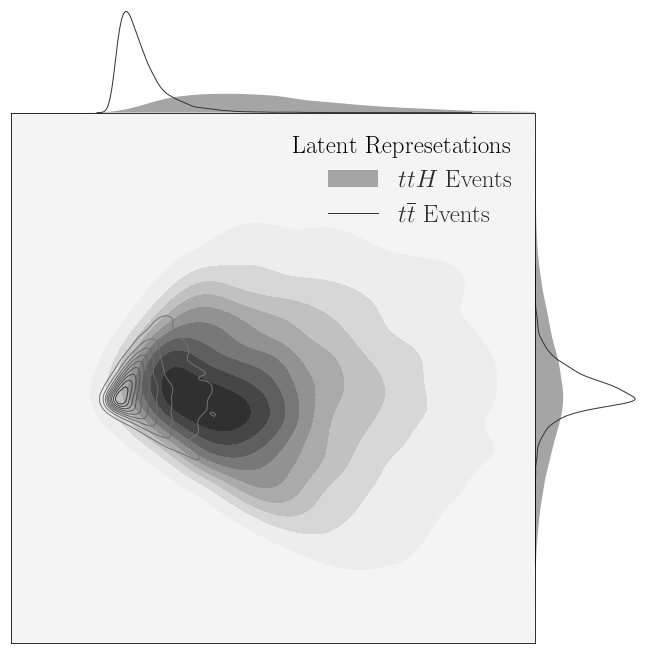

In [33]:
l2_yhat = LatentGetter(latent2.layers[0:3], condensed=True).predict(X_test_latent.numpy()[cut])
no_tsne= gen_tsne(l2_yhat, y_test_latent.numpy()[cut], text=r'Latent Represetations',
                  cmap=sns.cubehelix_palette(start=14/10, light=.97, as_cmap=True, hue=0), col_aux='#737373',
                  EMD=False,
         rotated=True, log=False, bnds=True, standardized=False)
no_tsne.savefig('figures/l2_notsne.pdf')

[ 3.24007488e-16 -4.54747351e-17] [14.73072588  6.65449338]


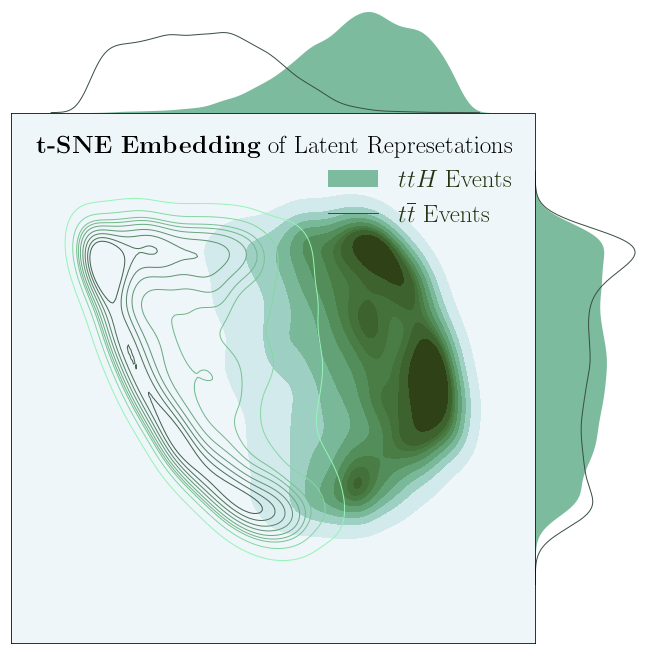

In [28]:
ax = gen_tsne(latent2_embedded, latent_label_28, text=r'\textbf{t-SNE Embedding} of Latent Represetations',
             cmap=sns.cubehelix_palette(start=14/10, light=.97, as_cmap=True), col_aux='#95f4b7',
              EMD=False)
ax.savefig('figures/l2_tsne_waxis.pdf')

In [ ]:
l64_yhat = LatentGetter(latent64.layers[0:3], condensed=True).predict(X_test.numpy()[cut])
print(emd(l64_yhat, y_test.numpy()[cut]))

In [ ]:
l8_yhat = LatentGetter(latent8.layers[0:3], condensed=True).predict(X_test_latent.numpy()[cut])
print(emd(l8_yhat, y_test_latent.numpy()[cut]))

In [ ]:
l2_yhat = LatentGetter(latent2.layers[0:3], condensed=True).predict(X_test_latent.numpy()[cut])
print(emd(l2_yhat, y_test_latent.numpy()[cut]))

In [ ]:
print(emd(np.array(X_test_ATLAS), y_test_ATLAS))

In [ ]:
TEMP_gen_tsne(latent64_embedded, latent_label, text=r'{Pairwise Architecture with} \boldmath$\mathbf{\ell=2^6}$ ',)

In [ ]:
TEMP_gen_tsne(latent8_embedded, latent_label, text=r'{Pairwise Architecture with} \boldmath$\mathbf{\ell=2^6}$ ',)

In [ ]:
TEMP_gen_tsne(latent2_embedded, latent_label, text=r'{Pairwise Architecture with} \boldmath$\mathbf{\ell=2^6}$ ',)

In [ ]:
TEMP_gen_tsne(ATLAS_embedded, latent_label, text=r'{Pairwise Architecture with} \boldmath$\mathbf{\ell=2^6}$ ',)

In [ ]:
ATLAS_embedded